<h1>5장 텍스트 클러스터링과 토픽 모델링</h1>
<i>다양한 언어 모델을 사용해 문서를 클러스터링하기.</i>

<a href="https://github.com/rickiepark/handson-llm"><img src="https://img.shields.io/badge/GitHub%20Repository-black?logo=github"></a>
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rickiepark/handson-llm/blob/main/chapter05.ipynb)

---

이 노트북은 <[핸즈온 LLM](https://tensorflow.blog/handson-llm/)> 책 5장의 코드를 담고 있습니다.

---

<a href="https://tensorflow.blog/handson-llm/">
<img src="https://tensorflow.blog/wp-content/uploads/2025/05/ed95b8eca688ec98a8_llm.jpg" width="350"/></a>

### [선택사항] - <img src="https://colab.google/static/images/icons/colab.png" width=100>에서 패키지 선택하기


이 노트북을 구글 코랩에서 실행한다면 다음 코드 셀을 실행하여 이 노트북에서 필요한 패키지를  설치하세요.

---

💡 **NOTE**: 이 노트북의 코드를 실행하려면 GPU를 사용하는 것이 좋습니다. 구글 코랩에서는 **런타임 > 런타임 유형 변경 > 하드웨어 가속기 > T4 GPU**를 선택하세요.

---


# 논문 초록(arXiv NLP 데이터) 을 이용해 다양한 언어 모델 기반의 텍스트 클러스터링과 토픽 모델링 전체 파이프라인을 실습

1. Sentence-BERT 임베딩
   - 문서를 384차원 벡터로 변환
2. UMAP 차원 축소
   - 임베딩을 2D/5D로 줄여 구조를 명확히 함
3. HDBSCAN 클러스터링
   - 클러스터 개수를 자동으로 찾고
   - 노이즈(-1) 문서는 자동 분리
4. BERTopic 모델링
   - 임베딩 + UMAP + HDBSCAN 조합
   - 각 토픽의 대표 키워드 및 토픽 구조 생성
5. 토픽 시각화
   - 문서–토픽 지도(datamap)
   - 토픽 간 유사도(heatmap)
   - 워드클라우드
6. 표현 모델 업데이트
   - KeyBERT, MMR, Flan-T5, GPT 등을 이용해
   - 토픽 설명/라벨을 더 자연스럽게 업데이트

In [1]:
%%capture
# %%capture : 이 셀에서 출력되는 모든 설치 메시지를 숨긴다.
# (설치 과정의 긴 로그를 화면에 보여주지 않도록 하는 기능)

!pip install umap-learn hdbscan bertopic datasets datamapplot
# 여러 라이브러리를 한 번에 설치한다.
# - umap-learn : 고차원 데이터를 2D/3D로 줄여서 시각화할 때 사용
# - hdbscan : 클러스터링(비슷한 데이터끼리 묶기) 알고리즘
# - bertopic : BERT 기반 토픽 모델링 도구
# - datasets : Hugging Face 데이터셋 로딩용 라이브러리
# - datamapplot : 데이터 시각화 도구

In [2]:
# 깃허브에서 위젯 상태 오류를 피하기 위해 진행 표시줄을 나타내지 않도록 설정합니다.
from transformers.utils import logging

logging.disable_progress_bar()

# 아카이브 논문: 계산 및 언어

In [3]:
# 허깅 페이스에서 데이터를 로드합니다.
from datasets import load_dataset

# "maartengr/arxiv_nlp" 데이터셋을 불러오고,
# 그중에서 'train' split(훈련용 데이터)만 가져온다.
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

# 데이터를 추출합니다.
# dataset 안에는 여러 컬럼이 있는데,
# 여기서는 논문 초록(Abstracts)과 제목(Titles)만 따로 꺼낸다.
abstracts = dataset["Abstracts"]   # 논문 초록 텍스트 목록
titles = dataset["Titles"]         # 논문 제목 목록

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

# 텍스트 클러스터링을 위한 파이프라인

## 1. 문서 임베딩

In [4]:
# 실행시간 약 4분 소요
from sentence_transformers import SentenceTransformer

# 각각의 초록(abstract)을 숫자 벡터로 바꾸기 위한 임베딩 모델을 불러옵니다.
# 'thenlper/gte-small'은 가벼우면서도 성능이 좋은 문장 임베딩 모델입니다.
embedding_model = SentenceTransformer('thenlper/gte-small')

# 초록 리스트 전체를 임베딩(숫자 벡터)으로 변환합니다.
# show_progress_bar=True : 변환 과정의 진행 상황을 표시해준다.
embeddings = embedding_model.encode(list(abstracts), show_progress_bar=True)
# 결과: 각 초록이 고정 길이의 벡터(예: 384차원)로 변환되어
#       이후 클러스터링이나 토픽 모델링에서 사용할 수 있다.

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [5]:
# 만들어진 임베딩의 차원을 확인합니다.
embeddings.shape
# 임베딩(embeddings)은 논문 초록들을 벡터로 변환한 결과입니다.
# shape는 (문서 개수, 벡터 차원 수)를 의미합니다.
#
# 예: (5000, 384)이면
#   - 5000개 초록이 있고,
#   - 각 초록이 384차원 벡터로 표현되었다는 뜻입니다.

(44949, 384)

## 2. 임베딩 차원 축소하기

### 📉 2차원 시각화를 위한 UMAP(Uniform Manifold Approximation and Projection)

UMAP은 고차원 벡터(예: 384차원 문장 임베딩) 를
더 낮은 차원(보통 2D 또는 3D)으로 줄여서 시각화할 수 있게 해주는 기법

📝 왜 2차원으로 줄일까?

- 문장 임베딩은 384차원처럼 매우 복잡한 공간에 있다.

- 인간은 2차원 그래프가 가장 이해하기 쉽고 직관적이다.

- UMAP은 비슷한 문장끼리는 가깝게, 다른 문장끼리는 멀게 배치하여
문서 구조를 시각적으로 확인할 수 있도록 도와준다.

⚙️ UMAP의 주요 하이퍼파라미터

- n_components

  - 최종 출력 차원

  - 2로 설정하면 2D 그래프를 그릴 수 있음

- min_dist

  - 점들이 얼마나 가까이 모일지 결정

  - 0.0에 가까울수록 촘촘하게 모임

- metric

  - 거리 계산 방식

  - 임베딩에는 보통 cosine 사용

In [6]:
from umap import UMAP

# 입력 임베딩(예: 384차원)을 더 작은 차원(5차원)으로 줄입니다.
# 이렇게 차원을 줄이면 클러스터링이나 토픽 모델링이 더 잘 되는 경우가 많습니다.
umap_model = UMAP(
    n_components=5,      # 최종 출력 차원 (여기서는 5차원)
    min_dist=0.0,        # 데이터가 얼마나 촘촘히 모이도록 할지 결정
    metric='cosine',     # 벡터 간 거리를 재는 방법 (코사인 거리를 사용)
    random_state=42,     # 실행할 때마다 같은 결과가 나오도록 고정
    n_jobs=1             # 사용할 CPU 코어 수
)

# UMAP 모델을 이용해 실제 차원 축소를 수행합니다.
reduced_embeddings = umap_model.fit_transform(embeddings)
# 결과는 (문서 수, 5차원) 형태의 새로운 임베딩으로 변환됩니다.

## 3. 축소된 임베딩 클러스터링

### 🧩 HDBSCAN Clustering

- HDBSCAN(Hierarchical Density-Based Spatial Clustering of Applications with Noise)은
- 복잡한 데이터에서 밀도를 기준으로 자동으로 클러스터를 찾아주는 알고리즘이다.
- 특히 문장 임베딩처럼 고차원·비선형 데이터에서 매우 효과적이다.

### 🔍 왜 HDBSCAN을 사용할까?

- k-means처럼 클러스터 개수를 미리 정할 필요 없음

- 밀도가 높은 지역을 중심으로 클러스터 자동 생성

- 노이즈(어느 그룹에도 속하지 않는 문서)를 -1로 구분해 제거

- UMAP 차원 축소와 매우 잘 맞아 토픽 모델링(BERTopic)에서 기본 조합으로 사용됨

### ⚙️ HDBSCAN의 핵심 개념
1. Density(밀도)

  - 비슷한 문서들이 많이 모여 있는 구역을 클러스터로 간주

  - 밀도가 낮으면 클러스터로 인정하지 않고 노이즈 처리

2. Hierarchical(계층적) 구조

  - 여러 스케일(크기)의 밀도 구조를 분석해
  - 가장 안정적인 클러스터를 자동으로 선택함

3. 클러스터 개수를 자동 결정

  - “몇 개로 묶을지?”를 직접 지정하지 않아도 된다

  - 데이터의 구조에 따라 자연스럽게 클러스터가 형성됨

### 🔧 주요 하이퍼파라미터

- min_cluster_size

  - 하나의 클러스터로 인정될 최소 샘플 수

  - 예: min_cluster_size=50 → 50개 이상 모여야 클러스터로 인정

- min_samples

  - “점 하나가 핵심 포인트로 인정되기 위한 최소 이웃 수”

기본값만 사용해도 좋은 결과가 자주 나온다.

In [7]:
from hdbscan import HDBSCAN

# HDBSCAN을 이용해 클러스터링(비슷한 문서끼리 자동으로 묶기)을 수행합니다.
# min_cluster_size=50 : 최소 50개 이상의 문서가 모여야 하나의 클러스터로 인정합니다.
hdbscan_model = HDBSCAN(min_cluster_size=50).fit(reduced_embeddings)

# 각 문서가 어떤 클러스터에 속했는지 나타내는 번호(labels_)를 가져옵니다.
clusters = hdbscan_model.labels_
# 예: [0, 0, 1, 2, -1, 0, ...]
# -1은 "아무 클러스터에도 속하지 못한 데이터(노이즈)"를 의미합니다.

# 클러스터 개수를 확인합니다.
len(set(clusters))
# set(clusters)는 클러스터 번호들의 집합을 의미합니다.
# 예: {0, 1, 2, -1}
# → 고유한 클러스터가 몇 개인지 확인할 수 있습니다.

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


155

## 4. 클러스터 조사

클러스터 0에 있는 처음 세 개의 문서를 수동으로 조사합니다:

In [8]:
list(abstracts)
# abstracts는 Hugging Face 데이터셋에서 가져온 "초록(abstract)" 컬럼이다.
# 데이터셋의 컬럼은 보통 리스트처럼 보이지만, 완전히 일반적인 리스트는 아니다.

# list(abstracts)는 이 컬럼을 "파이썬의 일반 리스트" 형태로 바꿔준다.
# 즉, ["초록1", "초록2", "초록3", ... ] 이런 형태의 리스트가 된다.
#
# 이렇게 리스트로 변환해야
# SentenceTransformer 같은 모델에서 쉽게 처리할 수 있다.

['  In this paper Arabic was investigated from the speech recognition problem\npoint of view. We propose a novel approach to build an Arabic Automated Speech\nRecognition System (ASR). This system is based on the open source CMU Sphinx-4,\nfrom the Carnegie Mellon University. CMU Sphinx is a large-vocabulary;\nspeaker-independent, continuous speech recognition system based on discrete\nHidden Markov Models (HMMs). We build a model using utilities from the\nOpenSource CMU Sphinx. We will demonstrate the possible adaptability of this\nsystem to Arabic voice recognition.\n',
 '  In this paper we present the creation of an Arabic version of Automated\nSpeech Recognition System (ASR). This system is based on the open source\nSphinx-4, from the Carnegie Mellon University. Which is a speech recognition\nsystem based on discrete hidden Markov models (HMMs). We investigate the\nchanges that must be made to the model to adapt Arabic voice recognition.\n  Keywords: Speech recognition, Acoustic mo

In [9]:
import numpy as np

# 클러스터 0에 있는 처음 세 개의 문서를 출력합니다
cluster = 0
# clusters == cluster :
#   각각의 문서가 어떤 클러스터에 속하는지 나타내는 배열(clusters)에서
#   '0번 클러스터'에 속한 문서들의 위치(index)를 찾아준다.

for index in np.where(clusters == cluster)[0][:3]:
    # np.where(...)[0] :
    #   조건(clusters == 0)을 만족하는 문서의 인덱스 목록을 가져온다.
    # [:3] :
    #   그중에서 처음 3개만 선택한다.

    print(list(abstracts)[index][:300] + "... \n")
    # list(abstracts)[index] :
    #   해당 인덱스에 있는 논문 초록(abstract) 한 개를 가져온다.
    #
    # [:300] :
    #   너무 길 수 있으므로 앞부분 300글자만 잘라서 출력한다.
    #
    # "... \n" :
    #   뒤에 '...'을 붙여 더 내용이 있음을 표시하고 줄바꿈한다.

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



그다음 시각화를 통해 생성된 클러스터를 이해하기 위해 임베딩을 2차원으로 줄입니다.

UMAP 2D 축소 → Pandas 데이터프레임 구성 → 정상 클러스터/이상치 분리

- UMAP으로 384차원 → 2차원으로 줄임

- Pandas DataFrame으로 x, y, 제목, 클러스터 정보 저장

- HDBSCAN에서 cluster = -1 은 “이상치(노이즈)”

- 정상 데이터와 이상치를 분리해 시각화할 때 유용함

In [10]:
import pandas as pd

# 384차원의 임베딩을 2차원으로 줄입니다.
# UMAP을 사용해 문서 임베딩을 시각화하기 좋은 2D(x, y)로 변환합니다.
reduced_embeddings = UMAP(
    n_components=2,        # 2차원으로 축소
    min_dist=0.0,          # 점들이 얼마나 가까이 모일지
    metric='cosine',       # 벡터 간 거리 계산 방식
    random_state=42,       # 재현성(실행할 때마다 같은 결과)
    n_jobs=1
).fit_transform(embeddings)

# 데이터프레임을 만듭니다.
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
# reduced_embeddings[:,0] → x좌표
# reduced_embeddings[:,1] → y좌표

df["title"] = titles
# 각 점에 해당하는 논문 제목을 함께 저장합니다.

df["cluster"] = [str(c) for c in clusters]
# HDBSCAN의 클러스터 번호를 문자열 형태로 저장합니다.
# 예: "0", "1", "2", ..., "-1"

# 정상치(클러스터)와 이상치를 선택합니다.
# HDBSCAN에서 -1은 "노이즈" 또는 "어느 클러스터에도 속하지 않은 문서"를 의미합니다.
clusters_df = df.loc[df.cluster != "-1", :]
# 정상적으로 클러스터에 배정된 문서들만 모아둠

outliers_df = df.loc[df.cluster == "-1", :]
# 클러스터에 속하지 못한 문서들만 모아둠 (이상치)

### 정적 그래프

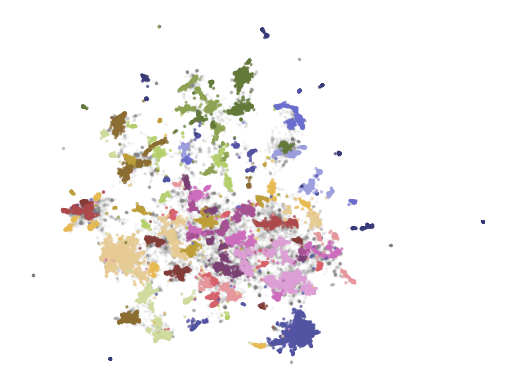

In [11]:
import matplotlib.pyplot as plt

# 이상치(outliers)와 정상 클러스터 데이터를 하나의 그래프에 시각화합니다.

# 먼저 이상치(클러스터 번호 = -1)를 회색 점으로 표시합니다.
plt.scatter(
    outliers_df.x,          # x좌표
    outliers_df.y,          # y좌표
    alpha=0.05,             # 점을 거의 투명하게 (밀집도만 보이도록)
    s=2,                    # 점 크기 작게
    c="grey"                # 색상: 회색
)

# 정상 데이터(클러스터에 속하는 문서들)를 색깔로 표시합니다.
plt.scatter(
    clusters_df.x,          # x좌표
    clusters_df.y,          # y좌표
    c=clusters_df.cluster.astype(int),  # 클러스터 번호별로 색상 구분
    alpha=0.6,              # 약간 투명하게
    s=2,                    # 점 크기
    cmap='tab20b'           # 색상 팔레트
)

plt.axis('off')  # x, y 축 숫자를 숨겨서 그래프만 보이게 함

# plt.savefig("matplotlib.png", dpi=300)
# ↑ 그래프를 PNG 파일로 저장하고 싶다면 이 줄을 활성화하세요.

plt.show()  # 그래프를 화면에 출력합니다.

# 텍스트 클러스터링에서 토픽 모델링으로

## BERTopic: 모듈화된 토픽 모델링 프레임워크

- BERTopic은 대량의 문서를 자동으로 주제(Topic) 별로 묶고,
- 각 주제를 대표하는 키워드(대표 단어) 를 찾아주는 토픽 모델링 기법이다.

### ⭐ BERTopic이 하는 일 한눈에 보기

1. 문장 임베딩(Embedding)

  - SBERT 등의 임베딩 모델로 문장을 숫자 벡터로 변환

2. UMAP 차원 축소

- 300 ~ 700차원 벡터를 2~5차원으로 줄여 구조를 더 명확하게 함

3. HDBSCAN 클러스터링

- 비슷한 문서끼리 자동으로 묶어 토픽을 형성

- 클러스터 개수를 사용자가 정할 필요 없음

4. c-TF-IDF로 대표 단어 추출

- 각 토픽을 가장 잘 설명하는 핵심 키워드를 뽑아냄


| 단계                   | 역할               |
| -------------------- | ---------------- |
| **Embedding(SBERT)** | 문장을 벡터로 변환       |
| **UMAP**             | 차원 축소로 군집 구조 선명화 |
| **HDBSCAN**          | 자동 클러스터링(토픽 생성)  |
| **c-TF-IDF**         | 토픽 대표 단어 추출      |


### 📌 어떻게 활용되는가?

- 논문/뉴스/리뷰 등 대량 텍스트의 주제 자동 분류

- 연구 리뷰 요약

- 고객 VOC/리뷰 자동 군집

- 교육·연구용 주제 분석 실습

In [12]:
from bertopic import BERTopic

# 앞서 정의한 모델들을 조합해 BERTopic 모델을 학습합니다.
topic_model = BERTopic(
    embedding_model=embedding_model,  # 문장을 숫자 벡터로 바꾸는 임베딩 모델 (SBERT 계열)
    umap_model=umap_model,            # 고차원 임베딩을 2~5차원으로 줄이는 모델
    hdbscan_model=hdbscan_model,      # 밀도 기반으로 클러스터(토픽) 찾아주는 모델
    verbose=True                      # 진행 과정을 화면에 보여줌
).fit(abstracts, embeddings)
# fit(abstracts, embeddings):
#   - abstracts : 실제 텍스트(논문 초록)
#   - embeddings : 텍스트를 벡터로 변환한 값
#
# BERTopic은 다음 과정을 자동으로 수행함:
#   1) SBERT 임베딩 → 문장 벡터화
#   2) UMAP → 차원 축소
#   3) HDBSCAN → 비슷한 문서끼리 토픽으로 묶기
#   4) c-TF-IDF → 각 토픽의 대표 단어 추출
#
# 결과적으로 여러 논문 초록을 자동으로 '주제(토픽)'별로 분류해 주는 모델이 만들어진다.

2025-11-19 01:18:31,188 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-19 01:19:25,767 - BERTopic - Dimensionality - Completed ✓
2025-11-19 01:19:25,770 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-19 01:19:35,338 - BERTopic - Cluster - Completed ✓
2025-11-19 01:19:35,352 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-19 01:19:42,159 - BERTopic - Representation - Completed ✓


위 코드를 실행하여 얻은 토픽을 살펴 보죠.

In [13]:
topic_model.get_topic_info()
# BERTopic이 찾아낸 전체 토픽 정보를 표 형태로 보여준다.
#
# 출력 내용 예:
#   - Topic 번호 (예: 0, 1, 2, ...)
#   - Count(문서 수) : 각 토픽에 몇 개의 문서가 포함되어 있는지
#   - Name : 토픽을 대표하는 핵심 단어들
#
# 즉, "어떤 토픽들이 만들어졌는지"와
# "각 토픽이 어떤 주요 단어들로 특징지어지는지"
# 한눈에 확인할 수 있는 요약 표이다.

Topic  Count                                           Name  \
0       -1  14210                               -1_of_the_and_to   
1        0   2316                   0_speech_asr_recognition_end   
2        1   2183                 1_question_qa_questions_answer   
3        2    941                 2_translation_nmt_machine_bleu   
4        3    880  3_summarization_summaries_summary_abstractive   
..     ...    ...                                            ...   
150    149     54          149_sentence_embeddings_sts_embedding   
151    150     54            150_gans_gan_adversarial_generation   
152    151     54         151_coherence_discourse_paragraph_text   
153    152     53                   152_chatgpt_its_openai_tasks   
154    153     52    153_opinion_reviews_summaries_summarization   

                                        Representation  \
0    [of, the, and, to, in, we, language, for, that...   
1    [speech, asr, recognition, end, acoustic, spea...   
2    [question, qa, questions, answer, answering, a...   
3    [translation, nmt, machine, bleu, neural, engl...   
4    [summarization, summaries, summary, abstractiv...   
..                                                 ...   
150  [sentence, embeddings, sts, embedding, similar...   
151  [gans, gan, adversarial, generation, generativ...   
152  [coherence, discourse, paragraph, text, cohesi...   
153  [chatgpt, its, openai, tasks, has, ai, capabil...   
154  [opinion, reviews, summaries, summarization, r...   

                                   Representative_Docs  
0    [  GPT-$3$ has attracted lots of attention due...  
1    [  The speech chain mechanism integrates autom...  
2    [  Text-based Question Generation (QG) aims at...  
3    [  Recently, the development of neural machine...  
4    [  Sentence summarization shortens given texts...  
..                                                 ...  
150  [  Sentence representation at the semantic lev...  
151  [  Text generation is of particular interest i...  
152  [  While there has been significant progress t...  
153  [  Over the last few years, large language mod...  
154  [  When faced with a large number of product r...  

[155 rows x 5 columns]

기본 모델을 사용해 수 백개의 토픽이 생성되었습니다. `get_topic()` 메서드를 사용해 토픽에 있는 상위 10개의 키워드와 c-TF-IDF 가중치를 얻을 수 있습니다.

In [14]:
topic_model.get_topic(0)
# 0번 토픽에 대한 대표 단어들을 보여준다.
#
# BERTopic은 각 토픽을 설명하는 핵심 단어들을 점수와 함께 반환한다.
# 예: [(단어1, 점수1), (단어2, 점수2), ...]
#
# 점수가 높을수록 그 단어가 해당 토픽을 더 잘 나타낸다는 의미이다.
#
# 즉, "토픽 0이 어떤 주제를 말하는지"를 파악할 수 있는
# 가장 중요한 단어 목록을 확인하는 기능이다.

[('speech', np.float64(0.028208883288593535)),
 ('asr', np.float64(0.018842312810416793)),
 ('recognition', np.float64(0.01351959051292077)),
 ('end', np.float64(0.009745990895354896)),
 ('acoustic', np.float64(0.009384710004108402)),
 ('speaker', np.float64(0.006877359138616964)),
 ('audio', np.float64(0.006785262733110495)),
 ('the', np.float64(0.006370412745274845)),
 ('error', np.float64(0.00634287314665723)),
 ('automatic', np.float64(0.0063065026437668335))]

`find_topics()` 함수를 사용하여 검색어를 기반으로 토픽을 찾을 수 있습니다. 토픽 모델링에 관한 토픽을 찾아 보죠:

In [15]:
topic_model.find_topics("topic modeling")
# 입력한 문장(여기서는 "topic modeling")과 가장 비슷한 토픽을 찾아준다.
#
# BERTopic은 각 토픽마다 대표 임베딩(벡터)을 가지고 있으며,
# 이 함수는 입력 문장과 토픽 임베딩 간의 유사도를 계산한다.
#
# 결과 예:
#   ([토픽 번호들], [유사도 점수들])
#   → 예: ([12, 3, 7], [0.85, 0.72, 0.68])
#
# 즉, "topic modeling"이라는 문장과 의미적으로 가장 가까운 토픽이 무엇인지
# 순위별로 알려주는 기능이다.

([24, -1, 38, 32, 84],
 [np.float32(0.9545274),
  np.float32(0.9123676),
  np.float32(0.9080541),
  np.float32(0.9053283),
  np.float32(0.90453553)])

토픽 24가 검색어와 비교적 유사도가 높습니다(0.95). 이 토픽을 조사해 보면 실제 토픽 모델링에 관한 토픽임을 알 수 있습니다.

In [16]:
topic_model.get_topic(24)
# 24번 토픽의 대표 단어들을 보여준다.
#
# BERTopic은 각 토픽마다 가장 중요한 단어(키워드)를 점수와 함께 반환한다.
# 예: [(단어1, 점수1), (단어2, 점수2), ...]
#
# 점수가 높을수록 그 단어가 토픽 24를 더 잘 설명한다는 의미이다.
#
# 즉, "24번 토픽이 어떤 주제를 말하는지"를 파악하기 위해
# 해당 토픽을 구성하는 핵심 단어들을 확인하는 기능이다.

[('topic', np.float64(0.06811153301756999)),
 ('topics', np.float64(0.035746717561104396)),
 ('lda', np.float64(0.016020062969070364)),
 ('latent', np.float64(0.013574936227317968)),
 ('documents', np.float64(0.013201698266173009)),
 ('document', np.float64(0.012912590658853182)),
 ('modeling', np.float64(0.012084716289729468)),
 ('dirichlet', np.float64(0.01010281253111858)),
 ('word', np.float64(0.008653858081603273)),
 ('allocation', np.float64(0.007950503995528465))]

BERTopic 논문이 토픽 24에 할당되어 있는지 확인해 보기

In [17]:
topic_model.topics_[titles.index(
    'BERTopic: Neural topic modeling with a class-based TF-IDF procedure'
)]
# titles 리스트 안에서 특정 논문 제목의 위치(index)를 찾는다.
# 예: titles.index('원하는 제목') → 해당 제목이 몇 번째에 있는지 반환.

# topic_model.topics_[...] :
#   위에서 찾은 인덱스를 이용해
#   그 논문이 어떤 토픽 번호(topic id)에 속했는지를 보여준다.

# 즉, "이 논문은 BERTopic 모델이 자동으로 만든 어떤 토픽에 포함되었는가?"
# 를 확인하는 코드이다.

24

### 시각화

**문서 시각화**

In [18]:
# 토픽과 문서를 시각화합니다.
fig = topic_model.visualize_documents(
    list(titles),                 # 각 점(point)에 표시될 문서 제목들
    reduced_embeddings=reduced_embeddings,  # UMAP으로 2차원으로 줄인 좌표(x, y)
    width=1200,                  # 그래프 가로 크기
    hide_annotations=True        # 점 위의 숫자/글자를 숨겨 깔끔하게 표시
)

# 범례 폰트를 업데이트합니다.
fig.update_layout(font=dict(size=16))
# 그래프에 표시되는 문자 크기를 키워 읽기 쉽게 만든다.

In [19]:
# 키워드 순서대로 막대 그래프를 그립니다.
topic_model.visualize_barchart()
# BERTopic이 찾은 각 토픽(topic)의 대표 키워드들을
# 막대 그래프(bar chart) 형태로 시각화해 보여준다.
#
# 이 그래프는 다음 정보를 확인하기 좋다:
#   - 각 토픽을 구성하는 핵심 단어들이 무엇인지
#   - 어떤 단어가 해당 토픽에서 얼마나 중요한지 (점수 순)
#
# 즉, "토픽이 어떤 내용인지 한눈에 이해할 수 있는"
# 가장 기본적인 BERTopic 시각화 도구이다.

In [20]:
# 토픽 사이의 관계를 시각화합니다.
topic_model.visualize_heatmap(n_clusters=30)
# BERTopic이 생성한 토픽들 사이의 "유사도 관계"를
# 히트맵(heatmap) 형태로 시각화해 보여준다.

# 히트맵은 색깔을 통해:
#   - 어떤 토픽끼리가 서로 비슷한지 (짙은 색)
#   - 어떤 토픽끼리가 서로 다른지 (옅은 색)
# 를 한눈에 확인할 수 있다.

# n_clusters=30 :
#   토픽들을 30개의 큰 그룹(클러스터)로 묶은 뒤,
#   그룹 간 유사도 구조를 보기 쉽게 정리한다.
#
# 즉, 전체 토픽 구조를 "큰 그림"으로 이해할 수 있도록 도와주는 시각화이다.

In [21]:
# 토픽 사이의 잠재적 계층 구조를 시각화합니다.
topic_model.visualize_hierarchy()
# BERTopic이 만든 토픽들을 "계층 구조(tree)" 형태로 보여주는 시각화입니다.
#
# 이 그래프에서는:
#   - 서로 비슷한 토픽끼리는 같은 가지(branch) 아래에 모이고
#   - 서로 다른 주제일수록 멀리 떨어져 있는 구조로 표시됩니다.
#
# 즉, 전체 토픽이 어떻게 큰 주제로 묶이고
# 그 안에서 다시 작은 토픽들로 나뉘는지를 한눈에 볼 수 있습니다.
#
# 예:
#   - "딥러닝" 관련 토픽이 하나의 큰 그룹으로 묶이고
#     그 아래에 "자연어처리", "컴퓨터비전", "모델 구조" 같은
#     하위 토픽이 배치되는 모습처럼 나타납니다.

## 표현 모델

- representation_model은 “토픽을 어떻게 설명할지”를 결정하는 모델

- KeyBERTInspired는 BERT 임베딩 기반으로 키워드를 뽑아주는 방식

- 결과적으로 더 자연스러운 토픽 키워드를 얻을 수 있음

다음 예제에서 모델을 훈련한 후에 토픽 표현을 업데이트하겠습니다. 이렇게 하면 빠르게 여러번 반복할 수 있습니다. 만약 훈련을 시작할 때 표현 모델을 사용하고 싶다면 다음과 같이 실행하세요:

```python
from bertopic.representation import KeyBERTInspired
from bertopic import BERTopic

# 표현 모델(Representation Model)을 만듭니다.
representation_model = KeyBERTInspired()
# KeyBERTInspired :
#   - BERTopic이 찾은 토픽을 더 잘 설명할 수 있도록
#     "대표 단어(키워드)"를 뽑아주는 모델입니다.
#   - 단어 중요도를 BERT 임베딩 기반으로 계산하는 방식이며,
#     일반 c-TF-IDF보다 더 자연스러운 키워드를 만들어줍니다.

# BERTopic의 기본 파이프라인 위에 표현 모델을 사용합니다.
topic_model = BERTopic(representation_model=representation_model)
# 여기서 BERTopic은 기본 구성(UMAP, HDBSCAN 등)을 그대로 사용하지만
# 대표 단어 생성 부분만 KeyBERTInspired 방식으로 교체됩니다.
#
# 즉,
#   - 토픽 묶기(클러스터링) → 기본 방식
#   - 토픽 대표 단어 생성 → KeyBERTInspired 방식
#
# 이렇게 하면 각 토픽을 더 자연스럽고 사람이 읽기 좋은 키워드로 표현할 수 있습니다.
```

표현 블록을 사용하기 전에 먼저 표현 모델을 사용할 때와 그렇지 않을 때를 비교하기 위해 원본 토픽 표현을 복사하겠습니다.

In [22]:
# 원본 표현(토픽의 대표 단어 목록)을 복사합니다.
from copy import deepcopy

original_topics = deepcopy(topic_model.topic_representations_)
# topic_model.topic_representations_ :
#   BERTopic이 계산한 "토픽별 대표 단어들"이 저장되어 있는 자료입니다.
#
# deepcopy(...) :
#   이 데이터를 '완전히 복사'해서 새로운 객체로 만든다는 뜻입니다.
#   이렇게 해야 나중에 토픽 표현을 변경하더라도
#   원래의 토픽 표현(original_topics)은 그대로 보존할 수 있습니다.
#
# 즉, 이후 실험을 위해 "토픽의 원본 상태"를 안전하게 백업해 두는 코드입니다.

- 원본 토픽 키워드와
업데이트된 토픽 키워드를 나란히 비교할 수 있는 표를 만든다.

- 토픽별 상위 5개 단어만 추려서 비교한다.

- 대표 단어 추출 방식이 달라졌을 때
(예: c-TF-IDF → KeyBERTInspired)
토픽 표현이 어떻게 달라졌는지 확인할 때 사용

In [23]:
def topic_differences(model, original_topics, nr_topics=5):
    """두 모델의 토픽 표현 차이를 표로 보여주는 함수입니다."""

    # 결과를 담을 비어 있는 데이터프레임을 만든다.
    # 각 행에는: 토픽 번호 / 원래 대표 단어 / 업데이트된 대표 단어
    df = pd.DataFrame(columns=["Topic", "Original", "Updated"])

    # nr_topics 개수만큼 토픽 비교 (기본값: 앞의 5개 토픽)
    for topic in range(nr_topics):

        # 원래 토픽의 상위 5개 키워드 추출
        # original_topics[topic] 구조: [(단어, 점수), (단어, 점수), ...]
        # zip(* ... )[0] 은 "단어들만" 가져오는 작업이다.
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])

        # 업데이트된(BERTopic이 새로운 표현 모델로 재계산한) 상위 5개 키워드 추출
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])

        # 한 행(row)을 데이터프레임에 추가
        df.loc[len(df)] = [topic, og_words, new_words]

    # 비교 결과 표 반환
    return df

### KeyBERTInspired

- `update_topics()`는 토픽 구조는 그대로 두고 대표 단어만 다시 계산한다.

- KeyBERTInspired는 BERT 임베딩 기반 중요한 단어를 뽑는 방식이다.

- `topic_differences()`로 업데이트 전/후의 대표 단어 변화 비교가 가능하다.

In [24]:
from bertopic.representation import KeyBERTInspired

# KeyBERTInspired를 사용해 토픽 표현(대표 단어)을 업데이트합니다.
representation_model = KeyBERTInspired()
# KeyBERTInspired:
#   - BERT 임베딩 기반으로 토픽을 더 자연스럽게 설명하는 단어들을 뽑아주는 모델입니다.
#   - 기존 c-TF-IDF보다 더 의미 중심의 단어를 추출하는 특징이 있습니다.

topic_model.update_topics(
    abstracts,
    representation_model=representation_model
)
# update_topics():
#   - 기존 토픽 구조(클러스터)는 그대로 유지하면서
#   - 토픽을 설명하는 키워드(대표 단어)만 새로운 방식으로 다시 계산합니다.
#   - 즉, "토픽 번호는 그대로", "대표 단어 목록만 새롭게 생성"하는 단계입니다.


# 토픽의 차이를 보여줍니다.
topic_differences(topic_model, original_topics)
# original_topics: 업데이트 전 토픽 키워드(백업본)
# topic_model: 업데이트 후 토픽 키워드
#
# topic_differences()는 두 목록을 비교하여
#   - 토픽 번호
#   - 기존 키워드 top 5
#   - 업데이트된 키워드 top 5
# 를 한 표에 보여줍니다.
#
# 즉, "표현 모델을 바꾸면 토픽 단어가 어떻게 달라지는지" 확인하는 용도입니다.

Topic                                           Original  \
0      0        speech | asr | recognition | end | acoustic   
1      1     question | qa | questions | answer | answering   
2      2        translation | nmt | machine | bleu | neural   
3      3  summarization | summaries | summary | abstract...   
4      4      hate | offensive | speech | detection | toxic   

                                             Updated  
0  phonetic | encoder | transcription | speech | ...  
1  answering | comprehension | questions | questi...  
2  translation | translate | translations | trans...  
3  summarization | summarizers | summaries | summ...  
4  hate | hateful | language | offensive | languages

### MMR(Maximal Marginal Relevance)

In [25]:
from bertopic.representation import MaximalMarginalRelevance

# MaximalMarginalRelevance(MMR)를 사용해 토픽 대표 단어를 업데이트합니다.
representation_model = MaximalMarginalRelevance(diversity=0.5)
# MMR(diversity=0.5):
#   - 토픽의 대표 단어를 고를 때,
#     "중요한 단어" + "서로 겹치지 않는 다양한 단어"를 균형 있게 선택하는 방식입니다.
#   - diversity 값이 높을수록 더 다양한 단어를 선택합니다.

topic_model.update_topics(
    abstracts,
    representation_model=representation_model
)
# 기존의 토픽 구조(클러스터)는 그대로 두고,
# 대표 단어만 MMR 방식으로 다시 계산합니다.


# 토픽의 차이를 보여줍니다.
topic_differences(topic_model, original_topics)
# original_topics : 업데이트 전 대표 단어 목록
# topic_model : 업데이트 후 대표 단어 목록
#
# topic_differences()는 두 결과를 비교한 표(DataFrame)를 만들어,
# 각 토픽에서 "대표 단어가 어떻게 바뀌었는지" 한눈에 보여줍니다.

Topic                                           Original  \
0      0        speech | asr | recognition | end | acoustic   
1      1     question | qa | questions | answer | answering   
2      2        translation | nmt | machine | bleu | neural   
3      3  summarization | summaries | summary | abstract...   
4      4      hate | offensive | speech | detection | toxic   

                                             Updated  
0           speech | asr | error | automatic | model  
1   questions | retrieval | comprehension | hop | to  
2       translation | nmt | bleu | neural | parallel  
3  summarization | document | extractive | rouge ...  
4   offensive | toxic | social | hateful | platforms

## 텍스트 생성



### Flan-T5

- Flan-T5는 Google에서 개발한 명령어 기반 파인튜닝(Instruction-Finetuned)된 언어 모델로, 기존의 강력한 T5(Text-to-Text Transfer Transformer) 모델을 개선한 버전입니다.

- 가장 큰 특징은 다양한 자연어 처리(NLP) 작업들을 자연어 명령(Instruction) 형태로 학습시켜, 특정 작업에 한정되지 않고 여러 작업에서 뛰어난 성능을 보이는 범용성을 갖추었다는 점입니다.

- 아래 코드는 Flan-T5를 사용해 사람처럼 자연스러운 토픽 설명을 자동 생성하는 예제

  - BERTopic의 기존 토픽 구조는 그대로 유지되고, 토픽의 ‘설명 문장(Topic Description)’만 LLM이 다시 작성해 준다.

  - `topic_differences()`를 통해 기존 표현과 LLM 표현을 비교할 수 있다.

In [26]:
from transformers import pipeline
from bertopic.representation import TextGeneration

# LLM에게 전달할 프롬프트(지시문)를 정의합니다.
prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?"""
# [DOCUMENTS]  : 해당 토픽에 들어 있는 문서들
# [KEYWORDS]   : 토픽의 대표 단어들
# → 두 정보를 기반으로 "이 토픽이 무엇을 의미하는지 한 문장으로 설명해줘"라고 요구하는 프롬프트


# Flan-T5 모델을 불러와 텍스트 생성 파이프라인을 만듭니다.
generator = pipeline('text2text-generation', model='google/flan-t5-small')
# Flan-T5-small :
#   - 가벼운 텍스트 생성 모델
#   - 지시어(prompt)를 주면 요약/설명/분류 등 다양한 작업 수행 가능


# TextGeneration을 사용해 '토픽 설명(Topic Description)'을 생성하는 표현 모델을 설정합니다.
representation_model = TextGeneration(
    generator,       # 위에서 만든 Flan-T5 생성기
    prompt=prompt,   # 토픽 설명용 프롬프트
    doc_length=50,   # LLM에게 넘길 문서 길이 제한
    tokenizer="whitespace"  # 단순 토크나이저 사용
)


# BERTopic의 토픽 표현(대표 문장/요약)을 LLM 기반으로 업데이트합니다.
topic_model.update_topics(
    abstracts,
    representation_model=representation_model
)
# update_topics():
#   - 토픽 구조(UMAP + HDBSCAN)는 그대로 유지하고,
#   - Flan-T5를 이용해 토픽 설명 문장을 새롭게 생성해 갱신합니다.
#   - 즉, '토픽 이름/요약'을 LLM이 더 자연스럽게 표현해주는 단계입니다.


# 업데이트 전/후 토픽 표현의 차이를 표로 확인합니다.
topic_differences(topic_model, original_topics)
# original_topics : 업데이트 전 토픽 키워드(백업본)
# topic_model     : Flan-T5로 업데이트된 토픽 표현
# → 두 버전을 나란히 비교하여 어떤 변화가 있었는지 확인

Device set to use cuda:0
100%|██████████| 155/155 [01:00<00:00,  2.56it/s]


Topic                                           Original  \
0      0        speech | asr | recognition | end | acoustic   
1      1     question | qa | questions | answer | answering   
2      2        translation | nmt | machine | bleu | neural   
3      3  summarization | summaries | summary | abstract...   
4      4      hate | offensive | speech | detection | toxic   

                                  Updated  
0  Speech-to-speech synthesis |  |  |  |   
1  Question answering systems |  |  |  |   
2                Science/Tech |  |  |  |   
3      Document summarization |  |  |  |   
4                Science/Tech |  |  |  |

### 오픈AI

In [ ]:
import openai
from bertopic.representation import OpenAI

# GPT에게 줄 프롬프트(지시문)를 정의합니다.
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short topic label in the following format:
topic: <short topic label>
"""
# [DOCUMENTS] : 해당 토픽에 속한 문서들
# [KEYWORDS]  : 토픽을 대표하는 주요 단어들
#
# GPT에게 "이 토픽을 짧게 이름 붙여줘"라고 요청하는 프롬프트입니다.


# GPT-3.5 모델을 사용해 토픽 표현(토픽 이름)을 업데이트합니다.
client = openai.OpenAI(api_key="YOUR_KEY_HERE")
# OpenAI API를 사용하기 위한 클라이언트 객체

representation_model = OpenAI(
    client,                   # GPT 모델을 호출할 때 사용할 클라이언트
    model="gpt-3.5-turbo",    # 사용할 LLM(GPT-3.5 Turbo)
    exponential_backoff=True, # 실패 시 자동 재시도(안정성 향상)
    chat=True,                # ChatGPT 스타일의 메시지 형식을 사용
    prompt=prompt             # 위에서 정의한 지시문
)
# OpenAI representation_model :
#   - 토픽 구조는 그대로 유지하고,
#   - GPT를 사용해 "토픽 이름(라벨)"을 새로 생성하는 표현 모델입니다.


topic_model.update_topics(abstracts, representation_model=representation_model)
# update_topics():
#   - 기존 토픽 구조(UMAP + HDBSCAN 클러스터)는 유지
#   - GPT가 만들어주는 "짧은 토픽 라벨"로 토픽 표현을 교체
#   - 예: "machine learning methods", "neural text generation" 같은 짧은 이름 생성


# 토픽의 차이를 보여줍니다.
topic_differences(topic_model, original_topics)
# original_topics : 변경 전 토픽 키워드(백업본)
# topic_model : GPT를 이용해 업데이트한 토픽 라벨
#
# 두 버전을 비교한 표(DataFrame)를 출력해
# GPT가 토픽 이름을 어떻게 개선했는지 확인할 수 있습니다.

100%|██████████| 150/150 [02:05<00:00,  1.20it/s]


Topic                                           Original  \
0      0     question | qa | answer | questions | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  medical | clinical | biomedical | patient | he...   
3      3  summarization | summaries | summary | abstract...   
4      4        translation | nmt | machine | bleu | neural   

                                             Updated  
0  Advanced Methods in Question Answering and Pas...  
1  Improving Speech Recognition Systems through A...  
2  Advancements in Medical Language Understanding...  
3     Advancements in Abstractive Text Summarization  
4  Neural Machine Translation Training and Improv...

Calculating medoids: 100%|██████████| 20/20 [00:06<00:00,  2.97it/s]


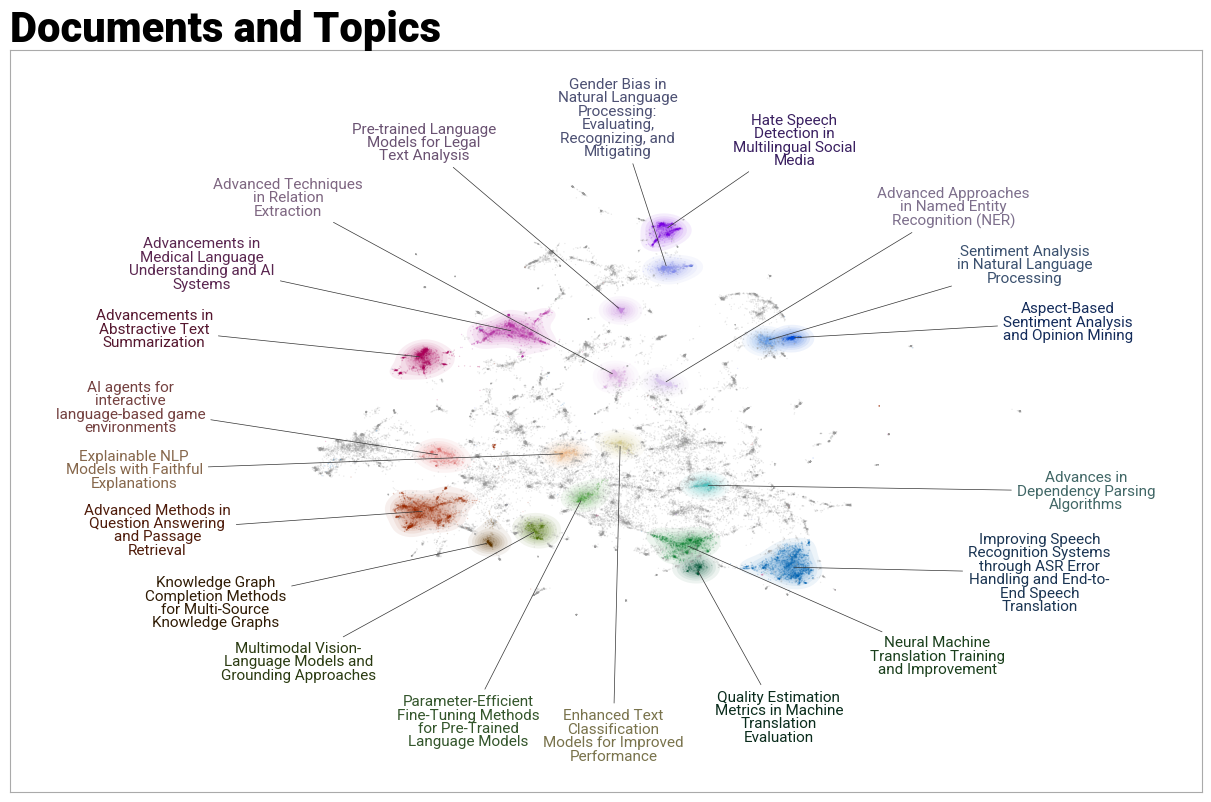

In [ ]:
# 토픽과 문서를 시각화합니다.
fig = topic_model.visualize_document_datamap(
    titles,                      # 각각의 문서에 표시할 제목 리스트
    topics=list(range(20)),      # 시각화할 토픽 번호(여기서는 0~19번)
    reduced_embeddings=reduced_embeddings,  # UMAP 2D 좌표
    width=1200,                  # 그래프 폭
    datamap_kwds={
        'label_wrap_width': 20,  # 긴 제목을 자동으로 줄바꿈
        'use_medoids': True,     # 각 토픽의 대표 문서를 중심에 표시
        'label_font_size': 11    # 글자 크기 설정
    }
)
# visualize_document_datamap():
#   - 문서(논문 제목)를 2D 평면에 뿌리고
#   - 가까운 문서끼리 자연스럽게 묶어서 '주제 지도(datamap)' 형태로 보여준다.
#   - 각 토픽의 대표 문서(centroid/medoid)를 중심에 배치해 구조를 파악하기 쉽게 한다.


plt.savefig("datamapplot.png", dpi=300)
# 만들어진 시각화 결과를 PNG 이미지로 저장합니다.

## 보너스: 워드 클라우드(Word Cloud)

다음 코드를 실행하려면 먼저 `wordcloud` 패키지를 설치하세요:


In [ ]:
!pip install wordcloud

먼저, 흥미로운 워드 클라우드를 만들기 위해 각 토픽이 10개 이상의 단어로 표현되어야 합니다.

In [ ]:
topic_model.update_topics(abstracts, top_n_words=500)
# BERTopic에서 각 토픽을 설명할 때 사용되는 "대표 단어 수"를 늘리는 코드입니다.
#
# 기본적으로 BERTopic은 토픽마다 상위 몇 개의 중요한 단어만 보여주는데,
# top_n_words=500 으로 설정하면
#   → 한 토픽에 대해 최대 500개의 키워드를 확인할 수 있게 됩니다.
#
# 즉, 토픽의 단어 범위를 더 넓게 보고 싶을 때 사용하는 옵션이며,
# 토픽 해석이나 분석을 더 자세하게 하고 싶을 때 유용합니다.

2025-08-10 07:46:43,696 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


다음 코드를 실행하여 'topic modeling' 토픽에 대한 워드 클라우드를 만듭니다:

- `model.get_topic(topic)` → 해당 토픽의 단어와 중요도(score) 목록 제공

- WordCloud는 중요도가 높을수록 단어를 크게 표시

- 시각적으로 “이 토픽이 어떤 주제를 갖는지” 직관적으로 파악할 수 있는 도구

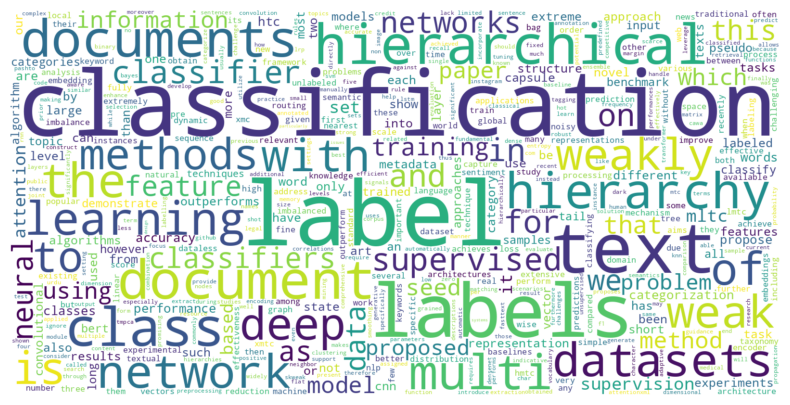

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    plt.figure(figsize=(10,5))

    # 해당 토픽의 (단어, 점수) 목록을 받아서
    # {단어: 점수} 형태의 딕셔너리로 변환합니다.
    # 워드클라우드는 단어 빈도나 점수를 기반으로 크기를 결정합니다.
    text = {word: value for word, value in model.get_topic(topic)}

    # WordCloud 객체 생성
    wc = WordCloud(
        background_color="white",  # 배경색
        max_words=1000,            # 최대 1000개의 단어 표시
        width=1600, height=800     # 이미지 크기 설정
    )

    # 토픽의 단어-점수 정보를 기반으로 워드클라우드 이미지를 생성합니다.
    wc.generate_from_frequencies(text)

    # 생성된 워드클라우드를 그림으로 표시합니다.
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")  # 축(눈금)을 숨겨 깔끔한 출력
    plt.show()


# 워드 클라우드를 출력합니다.
create_wordcloud(topic_model, topic=17)
# topic=17 : BERTopic에서 17번 토픽의 '대표 단어들'을 이용해 워드클라우드를 만든다.